<a href="https://colab.research.google.com/github/ibitabadger/AI-project/blob/main/03-Modelos_e_iteraciones.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno
#bibliotecas de machine learning
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_validate, ShuffleSplit

from sklearn.model_selection import learning_curve
from sklearn.metrics import mean_squared_error
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder
from sklearn import utils
from sklearn import preprocessing
from sklearn.model_selection import train_test_split,KFold,GroupKFold
import lightgbm as lgb
import gc


import warnings
warnings.filterwarnings('ignore')
import gdown

# URL de Google Drive del archivo compartido
google_drive_url = 'https://drive.google.com/uc?id=1G4cMAX3eYdRzwLpHNsVMAUavCZ5Fiieg'

# Descargar el archivo desde Google Drive
output_file = 'data.csv'
gdown.download(google_drive_url, output_file, quiet=False)

# Crear un DataFrame a partir del archivo descargado
df = pd.read_csv(output_file, delimiter=',')
df.to_csv('datos_modelo.csv', index=False)

# Impresión del dataframe
print(df.head())

Downloading...
From: https://drive.google.com/uc?id=1G4cMAX3eYdRzwLpHNsVMAUavCZ5Fiieg
To: /content/data.csv
100%|██████████| 54.4M/54.4M [00:01<00:00, 41.7MB/s]


   PUNTAJE  ESTRATO  TPERSONA  LAVADORA  ZONA  TCUARTOS  VIVIENDA  NIVEL  \
0    38.89      3.0       2.0       2.0     1       4.0       1.0    1.0   
1    38.89      3.0       2.0       2.0     1       4.0       1.0    1.0   
2    57.27      2.0       3.0       1.0     1       4.0       1.0    2.0   
3    57.27      2.0       3.0       1.0     1       4.0       1.0    2.0   
4    57.27      2.0       3.0       1.0     1       4.0       1.0    1.0   

   ALCANTA  TVCABLE  ...  CALENTA  INGRESOS  DUCHA  ACUEDUC  THOGAR  \
0      1.0      1.0  ...      2.0       0.0    1.0      1.0     1.0   
1      1.0      1.0  ...      2.0  500000.0    1.0      1.0     1.0   
2      1.0      2.0  ...      1.0  600000.0    1.0      1.0     1.0   
3      1.0      2.0  ...      1.0  680000.0    1.0      1.0     1.0   
4      1.0      2.0  ...      1.0       0.0    1.0      1.0     1.0   

   TCUARTOSVI  TIPODOC  TSANITAR  MOTO  TVCOLOR  
0         4.0      1.0       1.0   2.0      1.0  
1         4.0   

In [ ]:
#Función para reportar el error del modelo
def report_cv_score(z):

    #RMSE en prueba y entrenamiento
    lr_ts_score = z['test_score']*(-1)
    lr_tr_score = z['train_score']*(-1)
    lin_rmse_ts = np.sqrt(lr_ts_score)
    lin_rmse_tr = np.sqrt(lr_tr_score)
    print("RMSLE Test: ", "{:.5f}".format(np.mean(lin_rmse_ts)), "(±", "{:.8f}".format(np.std(lin_rmse_ts)),")")
    print("RMSLE Train: ", "{:.5f}".format(np.mean(lin_rmse_tr)), "(±", "{:.8f}".format(np.std(lin_rmse_tr)),")")

#Función para calcular el RMSLE de los modelos implementados
def RMSLE(y_actual, y_pred):

    return np.sqrt(mean_squared_error(y_actual, y_pred))

In [ ]:
# División de datos
X = df.drop('PUNTAJE', axis=1)
y = df['PUNTAJE']
Xtv, Xts, ytv, yts = train_test_split(X, y, test_size=0.3)

test_size = 0.3
val_size  = test_size/(1-test_size) # Elementos de validación

estimator1 = LinearRegression()
estimator2 = DecisionTreeRegressor(max_depth=5)
estimator3 = RandomForestRegressor(n_estimators = 2,max_depth = 5)

#Selección de modelos

zscores = []
estimators = [estimator1, estimator2, estimator3]
for estimator in estimators:
    print("---------")
    z = cross_validate(estimator, Xtv, ytv, return_train_score=True, return_estimator=False,
                       scoring="neg_mean_squared_error", cv=ShuffleSplit(n_splits=10, test_size=0.3))
    report_cv_score(z)
    zscores.append(np.mean(np.sqrt(z['test_score']*(-1))))
best = np.argmin(zscores)
print ("Seleccionado: ", best)
best_estimator = estimators[best]
print ("\n Mejor modelo: ")
print (best_estimator)

---------
RMSLE Test:  10.60444 (± 0.01822195 )
RMSLE Train:  10.58364 (± 0.00782774 )
---------
RMSLE Test:  11.92090 (± 0.01425346 )
RMSLE Train:  11.88921 (± 0.00790615 )
---------
RMSLE Test:  11.86309 (± 0.03955542 )
RMSLE Train:  11.84610 (± 0.02141216 )
Seleccionado:  0

 Mejor modelo: 
LinearRegression()


Mejores hiperparámetros para el modelo lineal:
{'fit_intercept': True}


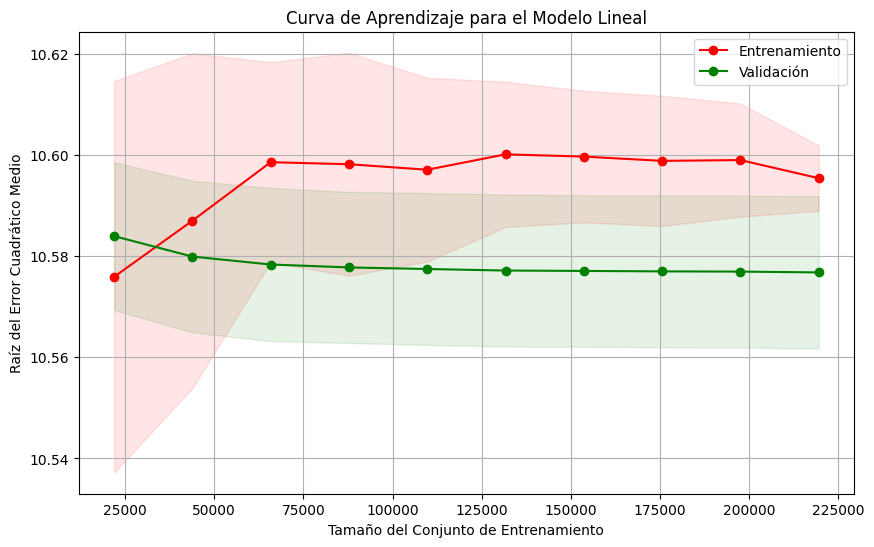

In [ ]:
from sklearn.model_selection import learning_curve
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt

# Definir hiperparámetros para búsqueda en cuadrícula
param_grid = {'fit_intercept': [True, False]}

# Inicializar el modelo lineal
linear_model = LinearRegression()

# Inicializar el objeto GridSearchCV
grid_search = GridSearchCV(linear_model, param_grid, cv=ShuffleSplit(n_splits=10, test_size=0.3),
                           scoring="neg_mean_squared_error", return_train_score=True)

# Ajustar el modelo a los datos de entrenamiento
grid_search.fit(Xtv, ytv)

# Mostrar los mejores hiperparámetros
print("Mejores hiperparámetros para el modelo lineal:")
print(grid_search.best_params_)

# Obtener el mejor modelo con los mejores hiperparámetros
best_linear_model = grid_search.best_estimator_

# Mostrar la curva de aprendizaje
train_sizes, train_scores, test_scores = learning_curve(best_linear_model, Xtv, ytv,
                                                        cv=ShuffleSplit(n_splits=10, test_size=0.3),
                                                        scoring="neg_mean_squared_error", train_sizes=np.linspace(0.1, 1.0, 10))

# Calcular la media y la desviación estándar de las puntuaciones
train_scores_mean = np.mean(np.sqrt(-train_scores), axis=1)
train_scores_std = np.std(np.sqrt(-train_scores), axis=1)
test_scores_mean = np.mean(np.sqrt(-test_scores), axis=1)
test_scores_std = np.std(np.sqrt(-test_scores), axis=1)

# Graficar la curva de aprendizaje
plt.figure(figsize=(10, 6))
plt.title("Curva de Aprendizaje para el Modelo Lineal")
plt.xlabel("Tamaño del Conjunto de Entrenamiento")
plt.ylabel("Raíz del Error Cuadrático Medio")
plt.grid()

plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Entrenamiento")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Validación")

plt.legend(loc="best")
plt.show()


Mejores hiperparámetros para el modelo RandomForestRegressor:
{'max_depth': None, 'min_samples_split': 5, 'n_estimators': 100}


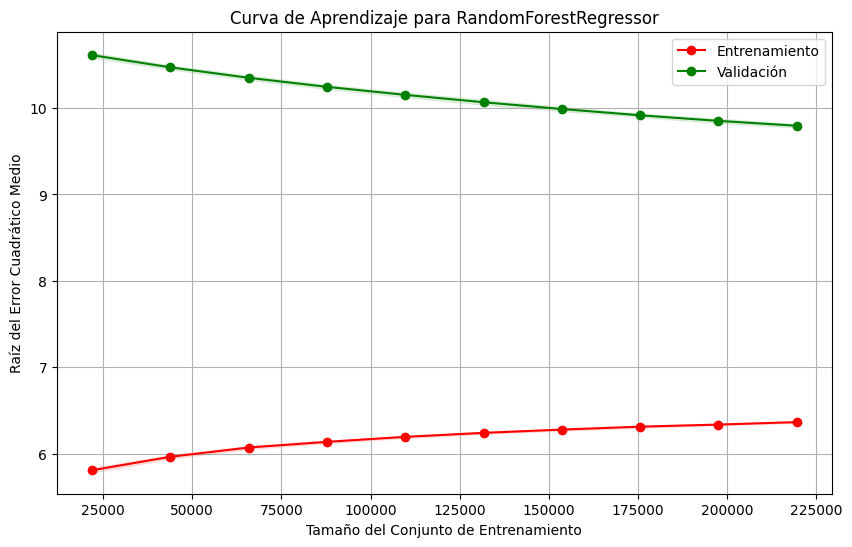

In [ ]:
from sklearn.model_selection import learning_curve
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt

# Definir hiperparámetros para búsqueda en cuadrícula
param_grid_rf = {
    'n_estimators': [50, 100],
    'max_depth': [None, 10],
    'min_samples_split': [2, 5]
}

# Inicializar el modelo RandomForestRegressor
rf_model = RandomForestRegressor()

# Inicializar el objeto GridSearchCV
grid_search_rf = GridSearchCV(rf_model, param_grid_rf, cv=ShuffleSplit(n_splits=10, test_size=0.3),
                               scoring="neg_mean_squared_error", return_train_score=True)

# Ajustar el modelo a los datos de entrenamiento
grid_search_rf.fit(Xtv, ytv)

# Mostrar los mejores hiperparámetros
print("Mejores hiperparámetros para el modelo RandomForestRegressor:")
print(grid_search_rf.best_params_)

# Obtener el mejor modelo con los mejores hiperparámetros
best_rf_model = grid_search_rf.best_estimator_

# Mostrar la curva de aprendizaje
train_sizes_rf, train_scores_rf, test_scores_rf = learning_curve(best_rf_model, Xtv, ytv,
                                                                cv=ShuffleSplit(n_splits=10, test_size=0.3),
                                                                scoring="neg_mean_squared_error", train_sizes=np.linspace(0.1, 1.0, 10))

# Calcular la media y la desviación estándar de las puntuaciones
train_scores_mean_rf = np.mean(np.sqrt(-train_scores_rf), axis=1)
train_scores_std_rf = np.std(np.sqrt(-train_scores_rf), axis=1)
test_scores_mean_rf = np.mean(np.sqrt(-test_scores_rf), axis=1)
test_scores_std_rf = np.std(np.sqrt(-test_scores_rf), axis=1)

# Graficar la curva de aprendizaje
plt.figure(figsize=(10, 6))
plt.title("Curva de Aprendizaje para RandomForestRegressor")
plt.xlabel("Tamaño del Conjunto de Entrenamiento")
plt.ylabel("Raíz del Error Cuadrático Medio")
plt.grid()

plt.fill_between(train_sizes_rf, train_scores_mean_rf - train_scores_std_rf, train_scores_mean_rf + train_scores_std_rf, alpha=0.1, color="r")
plt.fill_between(train_sizes_rf, test_scores_mean_rf - test_scores_std_rf, test_scores_mean_rf + test_scores_std_rf, alpha=0.1, color="g")
plt.plot(train_sizes_rf, train_scores_mean_rf, 'o-', color="r", label="Entrenamiento")
plt.plot(train_sizes_rf, test_scores_mean_rf, 'o-', color="g", label="Validación")

plt.legend(loc="best")
plt.show()


Mejores hiperparámetros para la combinación de Regresión Lineal y PCA:
{'linear_regression__fit_intercept': True, 'pca__n_components': 15}


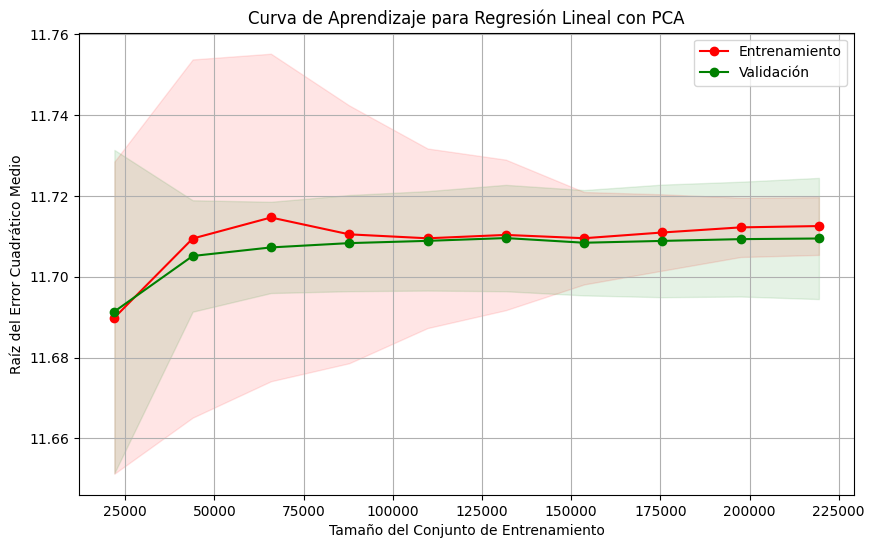

In [ ]:
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import learning_curve
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt

# Aplicar PCA seguido de regresión lineal
pipeline = Pipeline([
    ('pca', PCA(n_components=10)),
    ('linear_regression', LinearRegression())
])

# Definir hiperparámetros para búsqueda en cuadrícula
param_grid_combined = {
    'pca__n_components': [5, 10, 15],
    'linear_regression__fit_intercept': [True, False]
}

# Inicializar el objeto GridSearchCV
grid_search_combined = GridSearchCV(pipeline, param_grid_combined, cv=ShuffleSplit(n_splits=10, test_size=0.3),
                                    scoring="neg_mean_squared_error", return_train_score=True)

# Ajustar el modelo a los datos de entrenamiento
grid_search_combined.fit(Xtv, ytv)

# Mostrar los mejores hiperparámetros
print("Mejores hiperparámetros para la combinación de Regresión Lineal y PCA:")
print(grid_search_combined.best_params_)

# Obtener el mejor modelo con los mejores hiperparámetros
best_combined_model = grid_search_combined.best_estimator_

# Mostrar la curva de aprendizaje
train_sizes_combined, train_scores_combined, test_scores_combined = learning_curve(best_combined_model, Xtv, ytv,
                                                                                  cv=ShuffleSplit(n_splits=10, test_size=0.3),
                                                                                  scoring="neg_mean_squared_error", train_sizes=np.linspace(0.1, 1.0, 10))

# Calcular la media y la desviación estándar de las puntuaciones
train_scores_mean_combined = np.mean(np.sqrt(-train_scores_combined), axis=1)
train_scores_std_combined = np.std(np.sqrt(-train_scores_combined), axis=1)
test_scores_mean_combined = np.mean(np.sqrt(-test_scores_combined), axis=1)
test_scores_std_combined = np.std(np.sqrt(-test_scores_combined), axis=1)

# Graficar la curva de aprendizaje
plt.figure(figsize=(10, 6))
plt.title("Curva de Aprendizaje para Regresión Lineal con PCA")
plt.xlabel("Tamaño del Conjunto de Entrenamiento")
plt.ylabel("Raíz del Error Cuadrático Medio")
plt.grid()

plt.fill_between(train_sizes_combined, train_scores_mean_combined - train_scores_std_combined, train_scores_mean_combined + train_scores_std_combined, alpha=0.1, color="r")
plt.fill_between(train_sizes_combined, test_scores_mean_combined - test_scores_std_combined, test_scores_mean_combined + test_scores_std_combined, alpha=0.1, color="g")
plt.plot(train_sizes_combined, train_scores_mean_combined, 'o-', color="r", label="Entrenamiento")
plt.plot(train_sizes_combined, test_scores_mean_combined, 'o-', color="g", label="Validación")

plt.legend(loc="best")
plt.show()


Mejores hiperparámetros para la combinación de Árbol de Decisión y K-Means:
{'decision_tree__max_depth': 10, 'kmeans__n_clusters': 5}


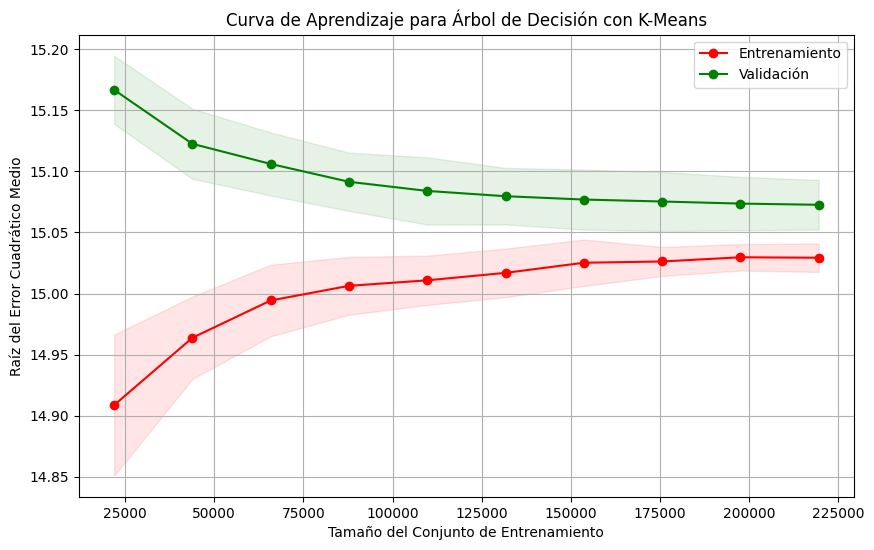

In [ ]:
from sklearn.cluster import KMeans
from sklearn.tree import DecisionTreeRegressor
from sklearn.pipeline import Pipeline
from sklearn.model_selection import learning_curve
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt

# Aplicar K-Means seguido de árbol de decisión
pipeline = Pipeline([
    ('kmeans', KMeans(n_clusters=5)),
    ('decision_tree', DecisionTreeRegressor(max_depth=5))
])

# Definir hiperparámetros para búsqueda en cuadrícula
param_grid_combined = {
    'kmeans__n_clusters': [3, 5, 7],
    'decision_tree__max_depth': [5, 10, 15]
}

# Inicializar el objeto GridSearchCV
grid_search_combined = GridSearchCV(pipeline, param_grid_combined, cv=ShuffleSplit(n_splits=10, test_size=0.3),
                                    scoring="neg_mean_squared_error", return_train_score=True)

# Ajustar el modelo a los datos de entrenamiento
grid_search_combined.fit(Xtv, ytv)

# Mostrar los mejores hiperparámetros
print("Mejores hiperparámetros para la combinación de Árbol de Decisión y K-Means:")
print(grid_search_combined.best_params_)

# Obtener el mejor modelo con los mejores hiperparámetros
best_combined_model = grid_search_combined.best_estimator_

# Mostrar la curva de aprendizaje
train_sizes_combined, train_scores_combined, test_scores_combined = learning_curve(best_combined_model, Xtv, ytv,
                                                                                  cv=ShuffleSplit(n_splits=10, test_size=0.3),
                                                                                  scoring="neg_mean_squared_error", train_sizes=np.linspace(0.1, 1.0, 10))

# Calcular la media y la desviación estándar de las puntuaciones
train_scores_mean_combined = np.mean(np.sqrt(-train_scores_combined), axis=1)
train_scores_std_combined = np.std(np.sqrt(-train_scores_combined), axis=1)
test_scores_mean_combined = np.mean(np.sqrt(-test_scores_combined), axis=1)
test_scores_std_combined = np.std(np.sqrt(-test_scores_combined), axis=1)

# Graficar la curva de aprendizaje
plt.figure(figsize=(10, 6))
plt.title("Curva de Aprendizaje para Árbol de Decisión con K-Means")
plt.xlabel("Tamaño del Conjunto de Entrenamiento")
plt.ylabel("Raíz del Error Cuadrático Medio")
plt.grid()

plt.fill_between(train_sizes_combined, train_scores_mean_combined - train_scores_std_combined, train_scores_mean_combined + train_scores_std_combined, alpha=0.1, color="r")
plt.fill_between(train_sizes_combined, test_scores_mean_combined - test_scores_std_combined, test_scores_mean_combined + test_scores_std_combined, alpha=0.1, color="g")
plt.plot(train_sizes_combined, train_scores_mean_combined, 'o-', color="r", label="Entrenamiento")
plt.plot(train_sizes_combined, test_scores_mean_combined, 'o-', color="g", label="Validación")

plt.legend(loc="best")
plt.show()
